In [4]:
## 라이브러리 불러오기
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 데이터 불러오기
dir_data = './dataset' 

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

## train/test/val 폴더 생성
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

## 전체 이미지 30개를 섞어줌
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

## 선택된 train 이미지를 npy 파일로 저장
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

## 선택된 val 이미지를 npy 파일로 저장
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

## 선택된 test 이미지를 npy 파일로 저장
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)


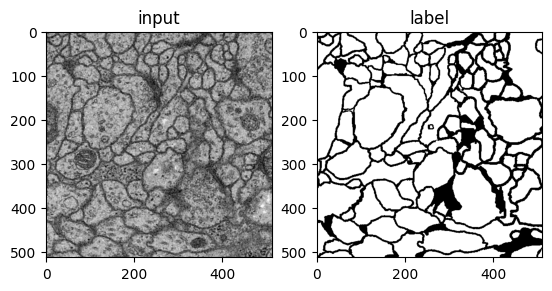

In [5]:
# 이미지 시각화
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')
  
plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')
  
plt.show()


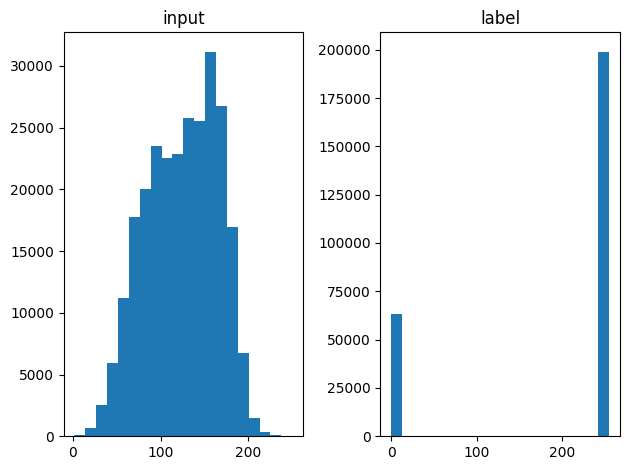

In [6]:
# 한 이미지 분포
plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()


# U-Net

In [62]:
# 라이브러리 import
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets


In [63]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Convolution + BatchNormalization + ReLU 정의
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            
            return cbr
        
        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.enc5_2 = CBR2d(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                         kernel_size=2, stride=2, padding=0, bias=True)
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, bias=True)
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    def forward(self, x):
        # 수축 경로(Contracting path)
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        
        enc5_1 = self.enc5_1(pool4)
        
        # 확장 경로(Expansive path)
        dec5_1 = self.enc5_2(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.fc(dec1_1)
        
        return x


In [64]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        lst_data = os.listdir(self.data_dir)
        
        lst_label = sorted([f for f in lst_data if f.startswith('label')])
        lst_input = sorted([f for f in lst_data if f.startswith('input')])
        
        if len(lst_label) != len(lst_input):
            raise ValueError("Number of labels and inputs do not match!")
        
        self.lst_label = lst_label
        self.lst_input = lst_input
        
    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        if index >= len(self.lst_label):
            raise IndexError(f"Index {index} is out of range for dataset of size {len(self.lst_label)}")
        
        label = np.load(os.path.join(self.data_dir, self.lst_label[index])).astype(np.float32) / 255.0
        input = np.load(os.path.join(self.data_dir, self.lst_input[index])).astype(np.float32) / 255.0
        
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]
        
        data = {'input': input, 'label': label}
        
        if self.transform:
            data = self.transform(data)
        
        return data


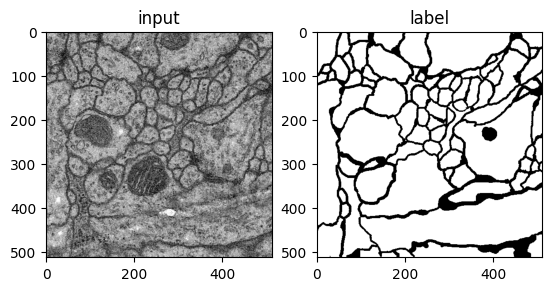

In [65]:
dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0)
input = data['input']
label = data['label']

# 이미지 시각화
plt.subplot(122)
plt.imshow(label.reshape(512, 512), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(512, 512), cmap='gray')
plt.title('input')

plt.show()


In [66]:
# Transform 구현하기
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)
        
        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}
        
        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std
        
    def __call__(self, data):
        label, input = data['label'], data['input']
        input = (input - self.mean) / self.std
        data = {'label': label, 'input': input}
        
        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)
            
        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)
        
        data = {'label': label, 'input': input}
        
        return data


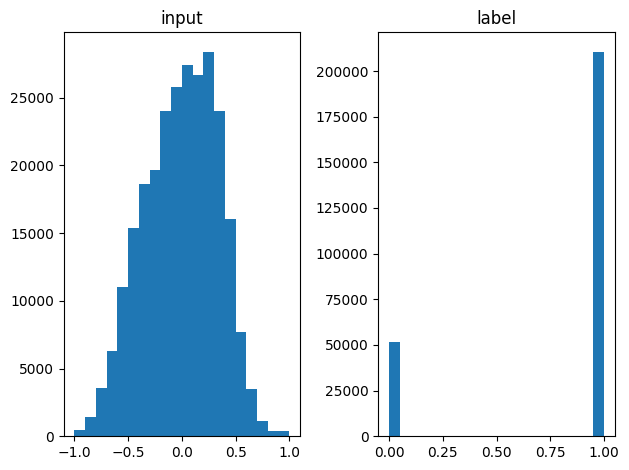

In [67]:
# Transform이 잘 구현되어있나 확인
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0)
input = data['input']
label = data['label']

# 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()


In [68]:
# 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    
    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
              "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

# 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch
    
    ckpt_list = os.listdir(ckpt_dir)
    ckpt_lst.sort(lambda f: int("".join(filter(str.isdigit, f))))
    
    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))
    
    net.load_state_dict(dict_model(['net']))
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('pth')[0])
    
    return net, optim, epoch


In [69]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 20

base_dir = '/home/students/cs/202121165/public_html/deepLearning/U-Net/dataset'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# 훈련을 위한 Transform과 DataLoader
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

# 네트워크 생성하기
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 50마다 모델 저장하기
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()


TRAIN: EPOCH 0001 / 0020 | BATCH 0001 / 0006 | LOSS 0.8176
TRAIN: EPOCH 0001 / 0020 | BATCH 0002 / 0006 | LOSS 0.7404
TRAIN: EPOCH 0001 / 0020 | BATCH 0003 / 0006 | LOSS 0.6989
TRAIN: EPOCH 0001 / 0020 | BATCH 0004 / 0006 | LOSS 0.6635
TRAIN: EPOCH 0001 / 0020 | BATCH 0005 / 0006 | LOSS 0.6314
TRAIN: EPOCH 0001 / 0020 | BATCH 0006 / 0006 | LOSS 0.6081
VALID: EPOCH 0001 / 0020 | BATCH 0001 / 0001 | LOSS 0.6023
TRAIN: EPOCH 0002 / 0020 | BATCH 0001 / 0006 | LOSS 0.4700
TRAIN: EPOCH 0002 / 0020 | BATCH 0002 / 0006 | LOSS 0.4892
TRAIN: EPOCH 0002 / 0020 | BATCH 0003 / 0006 | LOSS 0.4760
TRAIN: EPOCH 0002 / 0020 | BATCH 0004 / 0006 | LOSS 0.4642
TRAIN: EPOCH 0002 / 0020 | BATCH 0005 / 0006 | LOSS 0.4542
TRAIN: EPOCH 0002 / 0020 | BATCH 0006 / 0006 | LOSS 0.4474
VALID: EPOCH 0002 / 0020 | BATCH 0001 / 0001 | LOSS 0.5018
TRAIN: EPOCH 0003 / 0020 | BATCH 0001 / 0006 | LOSS 0.4008
TRAIN: EPOCH 0003 / 0020 | BATCH 0002 / 0006 | LOSS 0.4075
TRAIN: EPOCH 0003 / 0020 | BATCH 0003 / 0006 | LOSS 0.39

In [71]:
# 모델 테스트
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# Other variables
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# result 저장
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))
    
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
    net.eval()
    loss_arr = []
    
    for batch, data in enumerate(loader_test, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)
        
        output = net(input)
        
        # loss function
        loss = fn_loss(output, label)
        loss_arr += [loss.item()]
        
        print("Test: batch %04d / %04d | loss %.4f" % (batch, num_batch_test, np.mean(loss_arr)))
        
        # Tensorboard 저장
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))
        
        # 테스트 저장
        for j in range(label.shape[0]):
            id = num_batch_test * (batch - 1) + j
            
            plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')
            
            np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())
            
print('Average Test: batch %04d / %04d | loss %.4f' % (batch, num_batch_test, np.mean(loss_arr)))


Test: batch 0001 / 0001 | loss 0.2152
Average Test: batch 0001 / 0001 | loss 0.2152


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/anaconda3/lib/python3.11/multiprocessing/connection.py", line 177, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/anaconda3/lib/python3.11/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/anaconda3/lib/python3.11/multiprocessing/connection.py", line 360, in _close
    reader_close()
  File "/usr/anaconda

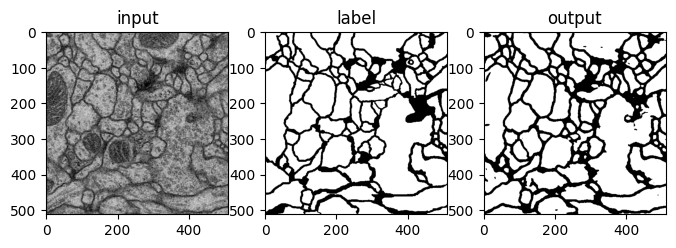

In [73]:
# Visualization
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

id = 0

label = np.load(os.path.join(result_dir, 'numpy', lst_label[id]))
input = np.load(os.path.join(result_dir, 'numpy', lst_input[id]))
output = np.load(os.path.join(result_dir, 'numpy', lst_output[id]))

# Plot 그리기
plt.figure(figsize=(8, 6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()
